In [ ]:
!pip install beautifulsoup4
!pip install requests
!python -m spacy download pt_core_news_sm

#installation of mallets package
import os
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip



In [ ]:
import logging
import os
import random
import warnings
import tempfile
import xml.etree.ElementTree as et
import zipfile
from itertools import chain
import re

import numpy

from gensim import utils, matutils
from gensim.models import basemodel
from gensim.models.ldamodel import LdaModel
from gensim.utils import check_output, revdict

#the wrapper was removed from the last version of Gensin library

logger = logging.getLogger(__name__)


class LdaMallet(utils.SaveLoad, basemodel.BaseTopicModel):
    """Python wrapper for LDA using `MALLET <http://mallet.cs.umass.edu/>`_.

    Communication between MALLET and Python takes place by passing around data files on disk
    and calling Java with subprocess.call().

    Warnings
    --------
    This is **only** python wrapper for `MALLET LDA <http://mallet.cs.umass.edu/>`_,
    you need to install original implementation first and pass the path to binary to ``mallet_path``.

    """
    def __init__(self, mallet_path, corpus=None, num_topics=100, alpha=50, id2word=None, workers=4, prefix=None,
                 optimize_interval=0, iterations=1000, topic_threshold=0.0, random_seed=0):
        """

        Parameters
        ----------
        mallet_path : str
            Path to the mallet binary, e.g. `/home/username/mallet-2.0.7/bin/mallet`.
        corpus : iterable of iterable of (int, int), optional
            Collection of texts in BoW format.
        num_topics : int, optional
            Number of topics.
        alpha : int, optional
            Alpha parameter of LDA.
        id2word : :class:`~gensim.corpora.dictionary.Dictionary`, optional
            Mapping between tokens ids and words from corpus, if not specified - will be inferred from `corpus`.
        workers : int, optional
            Number of threads that will be used for training.
        prefix : str, optional
            Prefix for produced temporary files.
        optimize_interval : int, optional
            Optimize hyperparameters every `optimize_interval` iterations
            (sometimes leads to Java exception 0 to switch off hyperparameter optimization).
        iterations : int, optional
            Number of training iterations.
        topic_threshold : float, optional
            Threshold of the probability above which we consider a topic.
        random_seed: int, optional
            Random seed to ensure consistent results, if 0 - use system clock.

        """
        self.mallet_path = mallet_path
        self.id2word = id2word
        if self.id2word is None:
            logger.warning("no word id mapping provided; initializing from corpus, assuming identity")
            self.id2word = utils.dict_from_corpus(corpus)
            self.num_terms = len(self.id2word)
        else:
            self.num_terms = 0 if not self.id2word else 1 + max(self.id2word.keys())
        if self.num_terms == 0:
            raise ValueError("cannot compute LDA over an empty collection (no terms)")
        self.num_topics = num_topics
        self.topic_threshold = topic_threshold
        self.alpha = alpha
        if prefix is None:
            rand_prefix = hex(random.randint(0, 0xffffff))[2:] + '_'
            prefix = os.path.join(tempfile.gettempdir(), rand_prefix)
        self.prefix = prefix
        self.workers = workers
        self.optimize_interval = optimize_interval
        self.iterations = iterations
        self.random_seed = random_seed
        if corpus is not None:
            self.train(corpus)

    def finferencer(self):
        """Get path to inferencer.mallet file.

        Returns
        -------
        str
            Path to inferencer.mallet file.

        """
        return self.prefix + 'inferencer.mallet'

    def ftopickeys(self):
        """Get path to topic keys text file.

        Returns
        -------
        str
            Path to topic keys text file.

        """
        return self.prefix + 'topickeys.txt'

    def fstate(self):
        """Get path to temporary file.

        Returns
        -------
        str
            Path to file.

        """
        return self.prefix + 'state.mallet.gz'

    def fdoctopics(self):
        """Get path to document topic text file.

        Returns
        -------
        str
            Path to document topic text file.

        """
        return self.prefix + 'doctopics.txt'

    def fcorpustxt(self):
        """Get path to corpus text file.

        Returns
        -------
        str
            Path to corpus text file.

        """
        return self.prefix + 'corpus.txt'

    def fcorpusmallet(self):
        """Get path to corpus.mallet file.

        Returns
        -------
        str
            Path to corpus.mallet file.

        """
        return self.prefix + 'corpus.mallet'

    def fwordweights(self):
        """Get path to word weight file.

        Returns
        -------
        str
            Path to word weight file.

        """
        return self.prefix + 'wordweights.txt'

    def corpus2mallet(self, corpus, file_like):
        """Convert `corpus` to Mallet format and write it to `file_like` descriptor.

        Format ::

            document id[SPACE]label (not used)[SPACE]whitespace delimited utf8-encoded tokens[NEWLINE]

        Parameters
        ----------
        corpus : iterable of iterable of (int, int)
            Collection of texts in BoW format.
        file_like : file-like object
            Opened file.

        """
        for docno, doc in enumerate(corpus):
            if self.id2word:
                tokens = chain.from_iterable([self.id2word[tokenid]] * int(cnt) for tokenid, cnt in doc)
            else:
                tokens = chain.from_iterable([str(tokenid)] * int(cnt) for tokenid, cnt in doc)
            file_like.write(utils.to_utf8("%s 0 %s\n" % (docno, ' '.join(tokens))))

    def convert_input(self, corpus, infer=False, serialize_corpus=True):
        """Convert corpus to Mallet format and save it to a temporary text file.

        Parameters
        ----------
        corpus : iterable of iterable of (int, int)
            Collection of texts in BoW format.
        infer : bool, optional
            ...
        serialize_corpus : bool, optional
            ...

        """
        if serialize_corpus:
            logger.info("serializing temporary corpus to %s", self.fcorpustxt())
            with utils.open(self.fcorpustxt(), 'wb') as fout:
                self.corpus2mallet(corpus, fout)

        # convert the text file above into MALLET's internal format
        cmd = \
            self.mallet_path + \
            " import-file --preserve-case --keep-sequence " \
            "--remove-stopwords --token-regex \"\\S+\" --input %s --output %s"
        if infer:
            cmd += ' --use-pipe-from ' + self.fcorpusmallet()
            cmd = cmd % (self.fcorpustxt(), self.fcorpusmallet() + '.infer')
        else:
            cmd = cmd % (self.fcorpustxt(), self.fcorpusmallet())
        logger.info("converting temporary corpus to MALLET format with %s", cmd)
        check_output(args=cmd, shell=True)

    def train(self, corpus):
        """Train Mallet LDA.

        Parameters
        ----------
        corpus : iterable of iterable of (int, int)
            Corpus in BoW format

        """
        self.convert_input(corpus, infer=False)
        cmd = self.mallet_path + ' train-topics --input %s --num-topics %s  --alpha %s --optimize-interval %s '\
            '--num-threads %s --output-state %s --output-doc-topics %s --output-topic-keys %s '\
            '--num-iterations %s --inferencer-filename %s --doc-topics-threshold %s  --random-seed %s'

        cmd = cmd % (
            self.fcorpusmallet(), self.num_topics, self.alpha, self.optimize_interval,
            self.workers, self.fstate(), self.fdoctopics(), self.ftopickeys(), self.iterations,
            self.finferencer(), self.topic_threshold, str(self.random_seed)
        )
        # NOTE "--keep-sequence-bigrams" / "--use-ngrams true" poorer results + runs out of memory
        logger.info("training MALLET LDA with %s", cmd)
        check_output(args=cmd, shell=True)
        self.word_topics = self.load_word_topics()
        # NOTE - we are still keeping the wordtopics variable to not break backward compatibility.
        # word_topics has replaced wordtopics throughout the code;
        # wordtopics just stores the values of word_topics when train is called.
        self.wordtopics = self.word_topics

    def __getitem__(self, bow, iterations=100):
        """Get vector for document(s).

        Parameters
        ----------
        bow : {list of (int, int), iterable of list of (int, int)}
            Document (or corpus) in BoW format.
        iterations : int, optional
            Number of iterations that will be used for inferring.

        Returns
        -------
        list of (int, float)
            LDA vector for document as sequence of (topic_id, topic_probability) **OR**
        list of list of (int, float)
            LDA vectors for corpus in same format.

        """
        is_corpus, corpus = utils.is_corpus(bow)
        if not is_corpus:
            # query is a single document => make a corpus out of it
            bow = [bow]

        self.convert_input(bow, infer=True)
        cmd = \
            self.mallet_path + ' infer-topics --input %s --inferencer %s ' \
                               '--output-doc-topics %s --num-iterations %s --doc-topics-threshold %s --random-seed %s'
        cmd = cmd % (
            self.fcorpusmallet() + '.infer', self.finferencer(),
            self.fdoctopics() + '.infer', iterations, self.topic_threshold, str(self.random_seed)
        )
        logger.info("inferring topics with MALLET LDA '%s'", cmd)
        check_output(args=cmd, shell=True)
        result = list(self.read_doctopics(self.fdoctopics() + '.infer'))
        return result if is_corpus else result[0]

    def load_word_topics(self):
        """Load words X topics matrix from :meth:`gensim.models.wrappers.ldamallet.LdaMallet.fstate` file.

        Returns
        -------
        numpy.ndarray
            Matrix words X topics.

        """
        logger.info("loading assigned topics from %s", self.fstate())
        word_topics = numpy.zeros((self.num_topics, self.num_terms), dtype=numpy.float64)
        if hasattr(self.id2word, 'token2id'):
            word2id = self.id2word.token2id
        else:
            word2id = revdict(self.id2word)

        with utils.open(self.fstate(), 'rb') as fin:
            _ = next(fin)  # header
            self.alpha = numpy.fromiter(next(fin).split()[2:], dtype=float)
            assert len(self.alpha) == self.num_topics, "mismatch between MALLET vs. requested topics"
            _ = next(fin)  # noqa:F841 beta
            for lineno, line in enumerate(fin):
                line = utils.to_unicode(line)
                doc, source, pos, typeindex, token, topic = line.split(" ")
                if token not in word2id:
                    continue
                tokenid = word2id[token]
                word_topics[int(topic), tokenid] += 1.0
        return word_topics

    def load_document_topics(self):
        """Load document topics from :meth:`gensim.models.wrappers.ldamallet.LdaMallet.fdoctopics` file.
        Shortcut for :meth:`gensim.models.wrappers.ldamallet.LdaMallet.read_doctopics`.

        Returns
        -------
        iterator of list of (int, float)
            Sequence of LDA vectors for documents.

        """
        return self.read_doctopics(self.fdoctopics())

    def get_topics(self):
        """Get topics X words matrix.

        Returns
        -------
        numpy.ndarray
            Topics X words matrix, shape `num_topics` x `vocabulary_size`.

        """
        topics = self.word_topics
        return topics / topics.sum(axis=1)[:, None]

    def show_topics(self, num_topics=10, num_words=10, log=False, formatted=True):
        """Get the `num_words` most probable words for `num_topics` number of topics.

        Parameters
        ----------
        num_topics : int, optional
            Number of topics to return, set `-1` to get all topics.
        num_words : int, optional
            Number of words.
        log : bool, optional
            If True - write topic with logging too, used for debug proposes.
        formatted : bool, optional
            If `True` - return the topics as a list of strings, otherwise as lists of (weight, word) pairs.

        Returns
        -------
        list of str
            Topics as a list of strings (if formatted=True) **OR**
        list of (float, str)
            Topics as list of (weight, word) pairs (if formatted=False)

        """
        if num_topics < 0 or num_topics >= self.num_topics:
            num_topics = self.num_topics
            chosen_topics = range(num_topics)
        else:
            num_topics = min(num_topics, self.num_topics)
            # add a little random jitter, to randomize results around the same alpha
            sort_alpha = self.alpha + 0.0001 * numpy.random.rand(len(self.alpha))
            sorted_topics = list(matutils.argsort(sort_alpha))
            chosen_topics = sorted_topics[: num_topics // 2] + sorted_topics[-num_topics // 2:]
        shown = []
        for i in chosen_topics:
            if formatted:
                topic = self.print_topic(i, topn=num_words)
            else:
                topic = self.show_topic(i, topn=num_words)
            shown.append((i, topic))
            if log:
                logger.info("topic #%i (%.3f): %s", i, self.alpha[i], topic)
        return shown

    def show_topic(self, topicid, topn=10, num_words=None):
        """Get `num_words` most probable words for the given `topicid`.

        Parameters
        ----------
        topicid : int
            Id of topic.
        topn : int, optional
            Top number of topics that you'll receive.
        num_words : int, optional
            DEPRECATED PARAMETER, use `topn` instead.

        Returns
        -------
        list of (str, float)
            Sequence of probable words, as a list of `(word, word_probability)` for `topicid` topic.

        """
        if num_words is not None:  # deprecated num_words is used
            warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")
            topn = num_words

        if self.word_topics is None:
            logger.warning("Run train or load_word_topics before showing topics.")
        topic = self.word_topics[topicid]
        topic = topic / topic.sum()  # normalize to probability dist
        bestn = matutils.argsort(topic, topn, reverse=True)
        beststr = [(self.id2word[idx], topic[idx]) for idx in bestn]
        return beststr

    def get_version(self, direc_path):
        """"Get the version of Mallet.

        Parameters
        ----------
        direc_path : str
            Path to mallet archive.

        Returns
        -------
        str
            Version of mallet.

        """
        try:
            archive = zipfile.ZipFile(direc_path, 'r')
            if u'cc/mallet/regression/' not in archive.namelist():
                return '2.0.7'
            else:
                return '2.0.8RC3'
        except Exception:

            xml_path = direc_path.split("bin")[0]
            try:
                doc = et.parse(xml_path + "pom.xml").getroot()
                namespace = doc.tag[:doc.tag.index('}') + 1]
                return doc.find(namespace + 'version').text.split("-")[0]
            except Exception:
                return "Can't parse pom.xml version file"

    def read_doctopics(self, fname, eps=1e-6, renorm=True):
        """Get document topic vectors from MALLET's "doc-topics" format, as sparse gensim vectors.

        Parameters
        ----------
        fname : str
            Path to input file with document topics.
        eps : float, optional
            Threshold for probabilities.
        renorm : bool, optional
            If True - explicitly re-normalize distribution.

        Raises
        ------
        RuntimeError
            If any line in invalid format.

        Yields
        ------
        list of (int, float)
            LDA vectors for document.

        """
        mallet_version = self.get_version(self.mallet_path)
        with utils.open(fname, 'rb') as fin:
            for lineno, line in enumerate(fin):
                if lineno == 0 and line.startswith(b"#doc "):
                    continue  # skip the header line if it exists

                parts = line.split()[2:]  # skip "doc" and "source" columns

                # the MALLET doctopic format changed in 2.0.8 to exclude the id,
                # this handles the file differently dependent on the pattern
                if len(parts) == 2 * self.num_topics:
                    doc = [
                        (int(id_), float(weight)) for id_, weight in zip(*[iter(parts)] * 2)
                        if abs(float(weight)) > eps
                    ]
                elif len(parts) == self.num_topics and mallet_version != '2.0.7':
                    doc = [(id_, float(weight)) for id_, weight in enumerate(parts) if abs(float(weight)) > eps]
                else:
                    if mallet_version == "2.0.7":
                        """

                            1   1   0   1.0780612802674239  30.005575655428533364   2   0.005575655428533364
                            2   2   0   0.9184413079632608  40.009062076892971008   3   0.009062076892971008
                            In the above example there is a mix of the above if and elif statement.
                            There are neither `2*num_topics` nor `num_topics` elements.
                            It has 2 formats 40.009062076892971008 and 0   1.0780612802674239
                            which cannot be handled by above if elif.
                            Also, there are some topics are missing(meaning that the topic is not there)
                            which is another reason why the above if elif fails even when the `mallet`
                            produces the right results

                        """
                        count = 0
                        doc = []
                        if len(parts) > 0:
                            while count < len(parts):
                                """
                                if section is to deal with formats of type 2 0.034
                                so if count reaches index of 2 and since int(2) == float(2) so if block is executed
                                now  there is one extra element afer 2, so count + 1 access should not give an error

                                else section handles  formats of type 20.034
                                now count is there on index of 20.034 since float(20.034) != int(20.034) so else block
                                is executed

                                """
                                if float(parts[count]) == int(parts[count]):
                                    if float(parts[count + 1]) > eps:
                                        doc.append((int(parts[count]), float(parts[count + 1])))
                                    count += 2
                                else:
                                    if float(parts[count]) - int(parts[count]) > eps:
                                        doc.append((int(parts[count]) % 10, float(parts[count]) - int(parts[count])))
                                    count += 1
                    else:
                        raise RuntimeError("invalid doc topics format at line %i in %s" % (lineno + 1, fname))

                if renorm:
                    # explicitly normalize weights to sum up to 1.0, just to be sure...
                    total_weight = float(sum(weight for _, weight in doc))
                    if total_weight:
                        doc = [(id_, float(weight) / total_weight) for id_, weight in doc]
                yield doc

    @classmethod
    def load(cls, *args, **kwargs):
        """Load a previously saved LdaMallet class. Handles backwards compatibility from
        older LdaMallet versions which did not use random_seed parameter.
        """
        model = super(LdaMallet, cls).load(*args, **kwargs)
        if not hasattr(model, 'random_seed'):
            model.random_seed = 0

        return model


def malletmodel2ldamodel(mallet_model, gamma_threshold=0.001, iterations=50):
    """Convert :class:`~gensim.models.wrappers.ldamallet.LdaMallet` to :class:`~gensim.models.ldamodel.LdaModel`.

    This works by copying the training model weights (alpha, beta...) from a trained mallet model into the gensim model.

    Parameters
    ----------
    mallet_model : :class:`~gensim.models.wrappers.ldamallet.LdaMallet`
        Trained Mallet model
    gamma_threshold : float, optional
        To be used for inference in the new LdaModel.
    iterations : int, optional
        Number of iterations to be used for inference in the new LdaModel.

    Returns
    -------
    :class:`~gensim.models.ldamodel.LdaModel`
        Gensim native LDA.

    """
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
        iterations=iterations,
        gamma_threshold=gamma_threshold,
        dtype=numpy.float64  # don't loose precision when converting from MALLET
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import time
from google.colab import drive
#import asyncio
drive.mount('/content/drive')
from urllib.parse import urlparse, urljoin

import re
import spacy
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk import tokenize
from collections import Counter
import string
import pandas as pd

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import math
from math import sqrt
#from gensim.models.wrappers import LdaMallet
   #importing os to set environment variable

mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'

Mounted at /content/drive


In [ ]:
from urllib.parse import urljoin

base_url = 'http://portal.mec.gov.br/'

urls = []

# Iterate over a range of values with a step of 20
for i in range(0, 1480, 20):
    # Construct the URL for searching news
    url_search = 'http://portal.mec.gov.br/todas-as-noticias?view=noticias&params[search_relevance]=&params[de]=01/01/2019&params[ate]=31/12/2022&params[catid]=&params[search_method]=exact&params[ord]=dt&start=' + str(i)

    # Create a session for making requests
    session = requests.Session()
    max_retries = 5
    retry_count = 0

    # Retry loop for handling connection errors
    while retry_count < max_retries:
        try:
            # Send a GET request to the search URL
            response = session.get(url_search)

            # Check if the request was successful (status code 200)
            if response.status_code == 200:
                html = response.content

                # Create a BeautifulSoup object to parse the HTML
                soup = BeautifulSoup(html, 'html.parser')
                text = soup.get_text()

                # Find all the div elements with class 'listagem'
                links = soup.find_all('div', class_='listagem')

                # Iterate over each 'div' element and extract the URLs
                for link in links:
                    link = link.find('a')

                    # Check if the 'a' element exists
                    if link:
                        href = link.get('href')

                        # Join the base URL with the extracted href value to get the complete URL
                        complete_url = urljoin(base_url, href)

                        # Append the complete URL to the list of URLs
                        urls.append(complete_url)

                # Break out of the retry loop once the URLs are extracted
                break

            else:
                # Print an error message if the request was not successful
                print(f"An error occurred while accessing the URL: {url_search}")
                break

        except requests.ConnectionError:
            # Increase the retry count and print a message for connection errors
            retry_count += 1

    else:
        # Print a message if the maximum number of retries is reached
        print("Unable to get URLs. The maximum number of attempts has been reached.")

# Print the total number of extracted URLs
print(len(urls))

In [ ]:
# Function to extract news text from a given URL
def get_text_news(url):
    session = requests.Session()
    max_retries = 20
    retry_count = 0

    # Retry loop to handle connection errors
    while retry_count < max_retries:
        try:
            # Send a GET request to the URL
            response = session.get(url)

            # Check if the response was successful
            if response.status_code == 200:
                # Extract the HTML content from the response
                html = response.content

                # Create a BeautifulSoup object to parse the HTML
                soup = BeautifulSoup(html, 'html.parser')

                # Extract the text content from the HTML
                text = soup.get_text()

                # Find the start and end indices of the news text
                start_index = text.find("Código para do Twitter") + len("Código para do Twitter")
                end_index = text.find("Fim do conteúdo da página", start_index)

                # Extract the news text within the specified indices
                extracted_text = text[start_index:end_index].strip()

                # Return the extracted news text
                return extracted_text
            else:
                # If the response status code is not 200, handle the error
                print(f"An error occurred while accessing the URL: {url}")
                return None
        except requests.ConnectionError:
            # If a connection error occurs, retry the request
            retry_count += 1
            print(f"Attempt {retry_count} failed. Trying again...")

    # If maximum retries are reached, print an error message
    print("Unable to get the news. The maximum number of attempts has been reached.")
    return None

# List to store the extracted news text
text_news = []

# Loop over each URL in the 'urls' list
for url in urls:

    # Call the 'get_text_news' function to extract news text from the URL
    text_new = get_text_news(url)

    # Check if the extracted news text is not None (i.e., extraction was successful)
    if text_new:
        # Append the extracted news text to the 'text_news' list
        text_news.append(text_new)

# Create a DataFrame with the extracted news text
df_news = pd.DataFrame(text_news, columns=['Original_text'])
df_news


In [ ]:
# Convert 'Original_text' column to string data type and transform capital letters
df['Original_text'] = df['Original_text'].astype(str)

# Convert capital letters to lowercase
df['Original_text'] = df['Original_text'].str.lower()

# Define a string of punctuation characters including square brackets
punctuation_chars = r'''!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'''

# Remove digits, punctuation characters, and square brackets from 'Original_text' column
df['Clean_text'] = df['Original_text'].apply(lambda x: re.sub(r'[\d{}]+'.format(re.escape(punctuation_chars)), '', x))
df['Clean_text'] = df['Clean_text'].str.replace(r'\[|\]', '')

# Remove accents from text
df['Processed_text'] = df['Clean_text'].apply(lambda x: unidecode(x))

# Download stopwords from Portuguese corpus
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

# Remove stop words and words starting with capital letters
df['Processed_text'] = df['Processed_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stopwords]))

# Apply lemmatization to the tokenized text in the 'Processed_text' column
nlp = spacy.load('pt_core_news_sm')
df['Lemma_text'] = df['Processed_text'].apply(lambda x: ([token.lemma_ for token in nlp(x)]))

# Write a .csv file
df.to_csv('news.csv')

# Display the DataFrame
df


In [ ]:
# Create bigrams using gensim's Phrases model
bigram = gensim.models.Phrases(df['Lemma_text'], min_count=1, threshold=1) # higher threshold yields fewer phrases

# Construct the bigram model
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Create trigrams using gensim's Phrases model, based on the bigram model
trigram = gensim.models.Phrases(bigram[df['Lemma_text']], threshold=1)

# Construct the trigram model
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Apply the trigel to the 'Stemmer_text' column and store the result in 'Trigram' column
df['Trigram'] = df['Lemma_text'].apply(lambda x: trigram_mod[bigram_mod[x]])

df


In [ ]:
get_most_freq_words([ word for interv in df['Trigram'] for word in interv],50)

In [1]:

stopwords = ['contar', 'ser', 'ter', 'bem',
             'todo', 'caso', 'dar', 'em', 'este', 'de', 'mec', 'compartilhar', '_o', 'ano', 'sao', 'tambem', 'esse', 'fazer', 'nao',
             'ja', 'outro', 'aler']

# Join the lists of strings into a single string
df['Trigram'] = df['Trigram'].apply(lambda x: ' '.join(x))

# Remove additional stopwords, including words starting with "_"
df['Trigram'] = df['Trigram'].apply(lambda x: re.sub(r'\b(_\w+)\b', '', x))

# Split the string back into a list of strings
df['Trigram'] = df['Trigram'].apply(lambda x: x.split())

# Remove empty lists and stopwords
df['Trigram'] = df['Trigram'].apply(lambda x: [word for word in x if word and word.lower() not in stopwords])

NameError: ignored

In [ ]:
get_most_freq_words([ word for interv in df['Trigram'] for word in interv],50)

In [ ]:
# Remove caracteres especiais e símbolos do texto
def remove_special_characters(text):
    # Define os caracteres especiais e símbolos que deseja remover
    special_chars = r'[^\w\s]'
    # Remove os caracteres especiais e símbolos do texto
    cleaned_text = re.sub(special_chars, '', text)
    return cleaned_text

# Aplica a remoção de caracteres especiais e símbolos para cada trigram_list
cleaned_trigram_lists = [[remove_special_characters(word) for word in trigram_list] for trigram_list in trigram_lists]

# Cria o dicionário
dictionary = Dictionary(cleaned_trigram_lists)

# Constrói o corpus
corpus = [dictionary.doc2bow(trigram_list) for trigram_list in cleaned_trigram_lists]


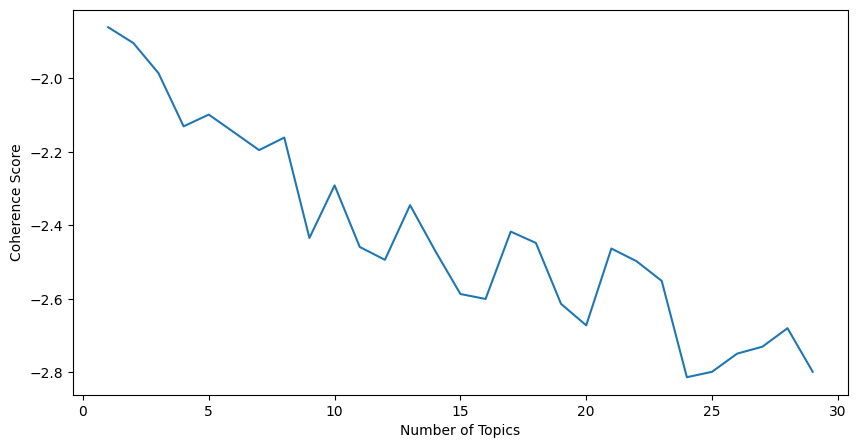

In [ ]:
coherence = []
for nb_topics in range(1,30):
    ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=nb_topics, id2word=dictionary, random_seed = 17)
    gensimmodel = malletmodel2ldamodel(ldamallet)

    cohm = CoherenceModel(model=gensimmodel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    coherence.append(coh)


# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,30), coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

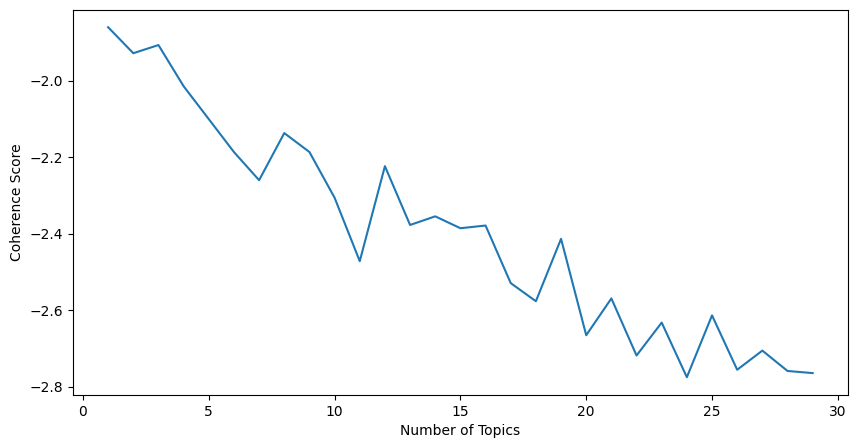

In [ ]:
# compute coherence
coherence = []
for nb_topics in range(1,30):
    ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=nb_topics, id2word=dictionary, random_seed = 63)
    gensimmodel = malletmodel2ldamodel(ldamallet)

    cohm = CoherenceModel(model=gensimmodel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    coherence.append(coh)


# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,30), coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

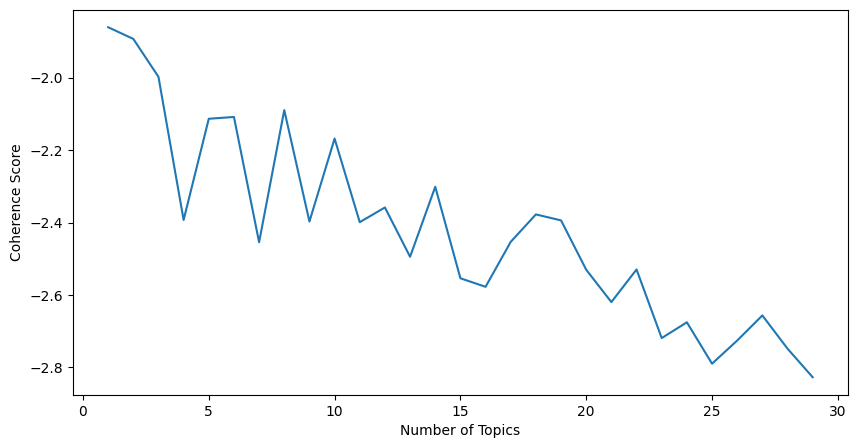

In [ ]:
# compute coherence
coherence = []
for nb_topics in range(1,30):
    ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=nb_topics, id2word=dictionary, random_seed = 0)
    gensimmodel = malletmodel2ldamodel(ldamallet)

    cohm = CoherenceModel(model=gensimmodel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    coherence.append(coh)


# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,30), coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

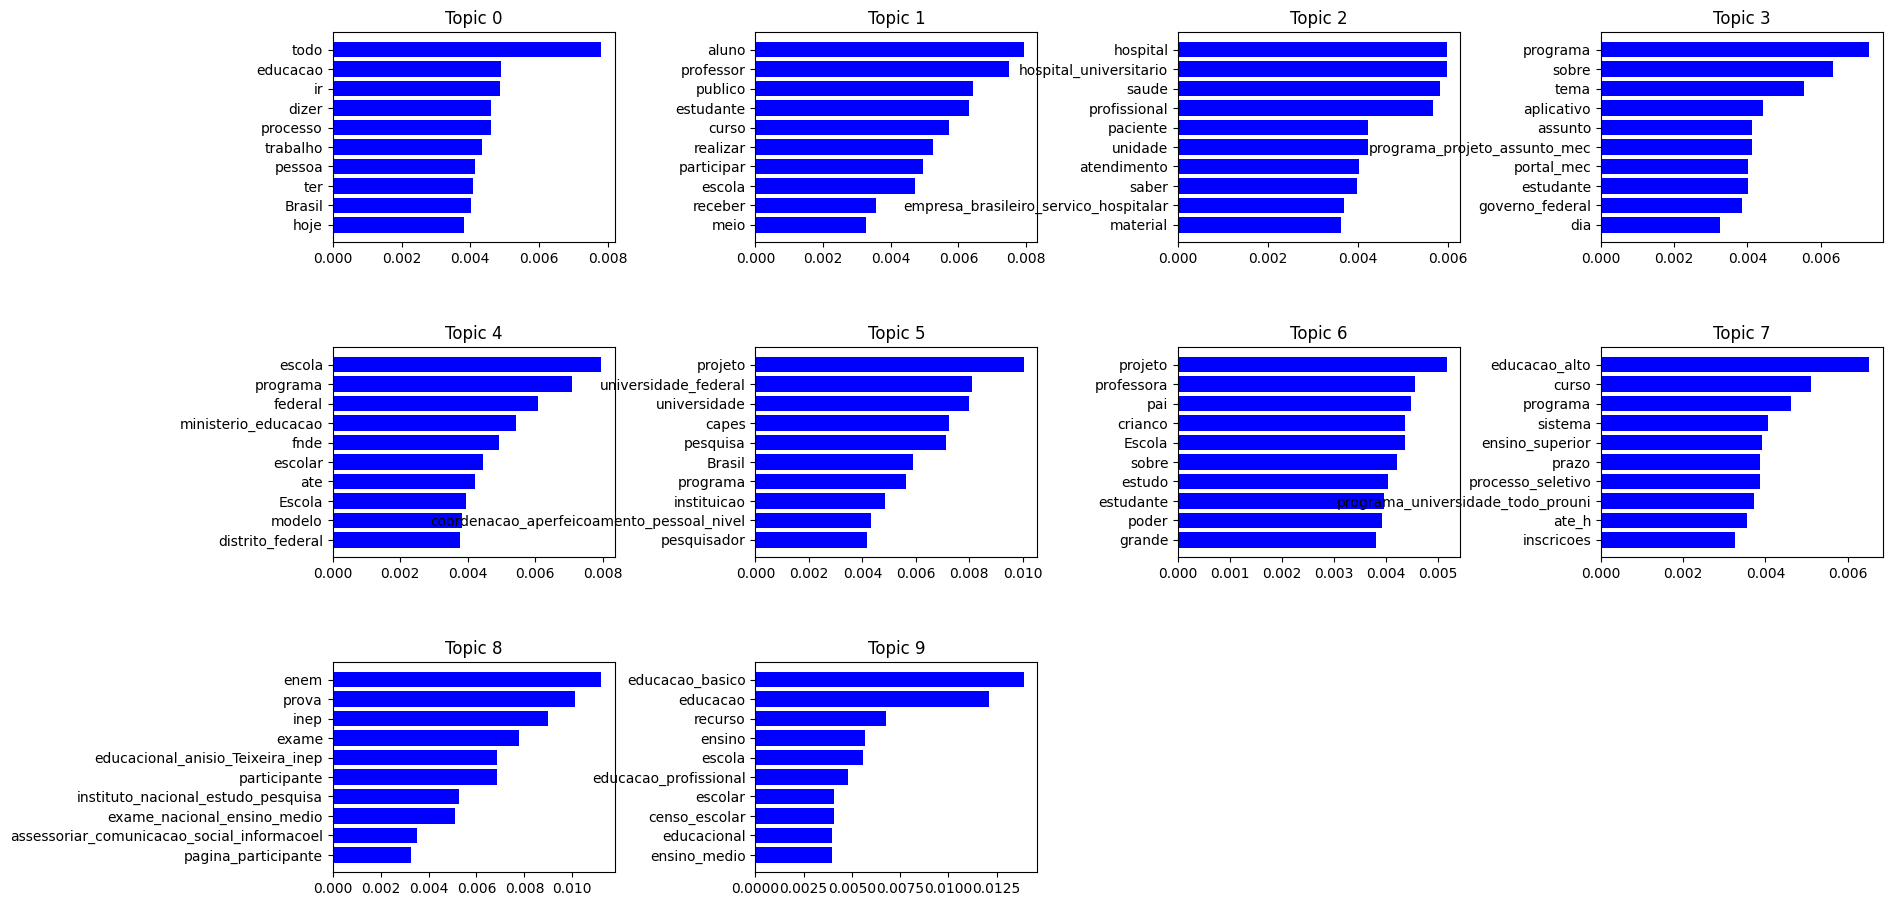

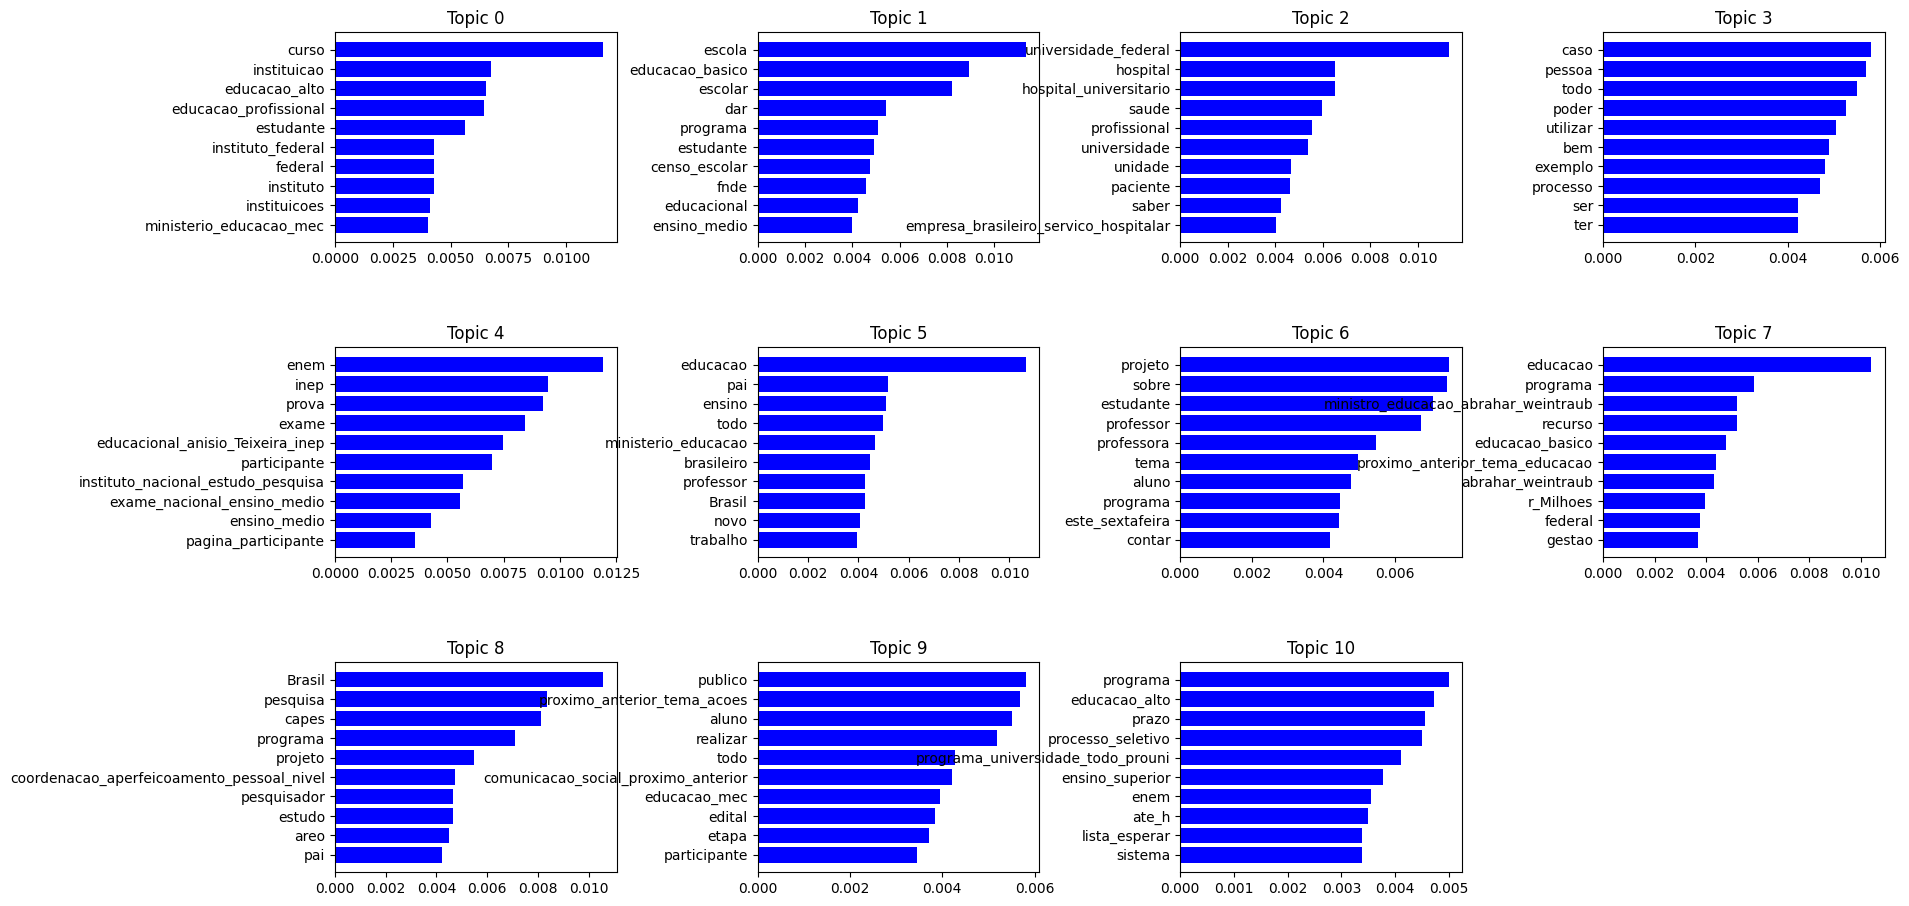

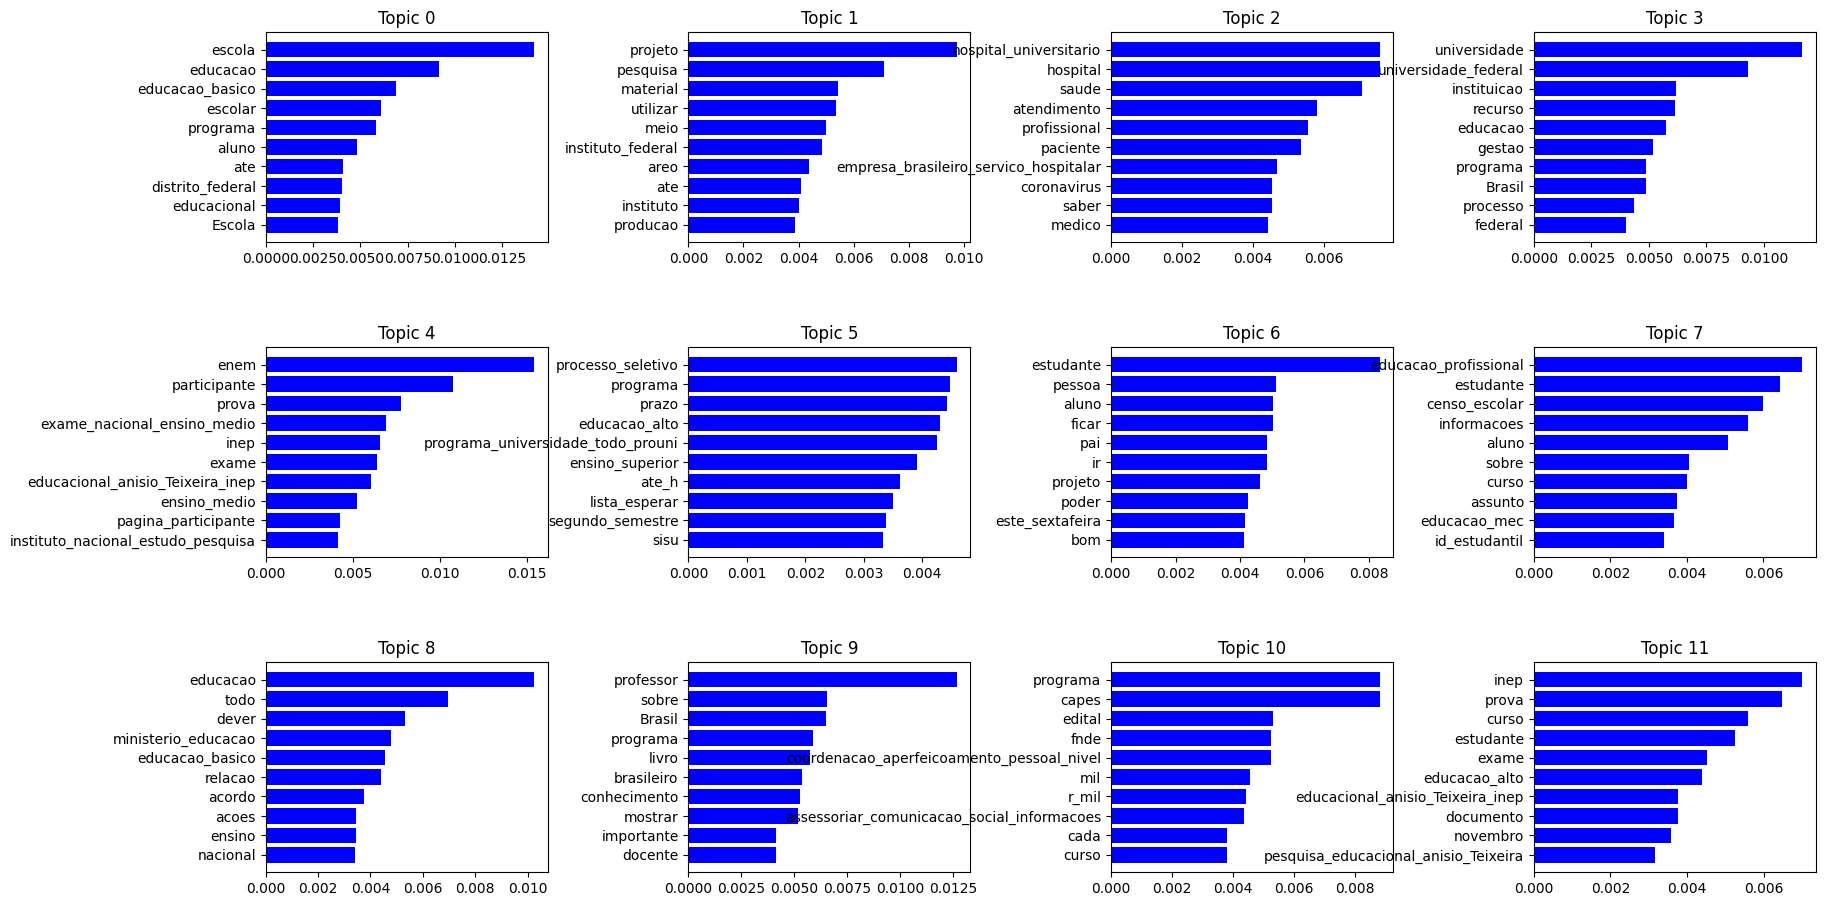

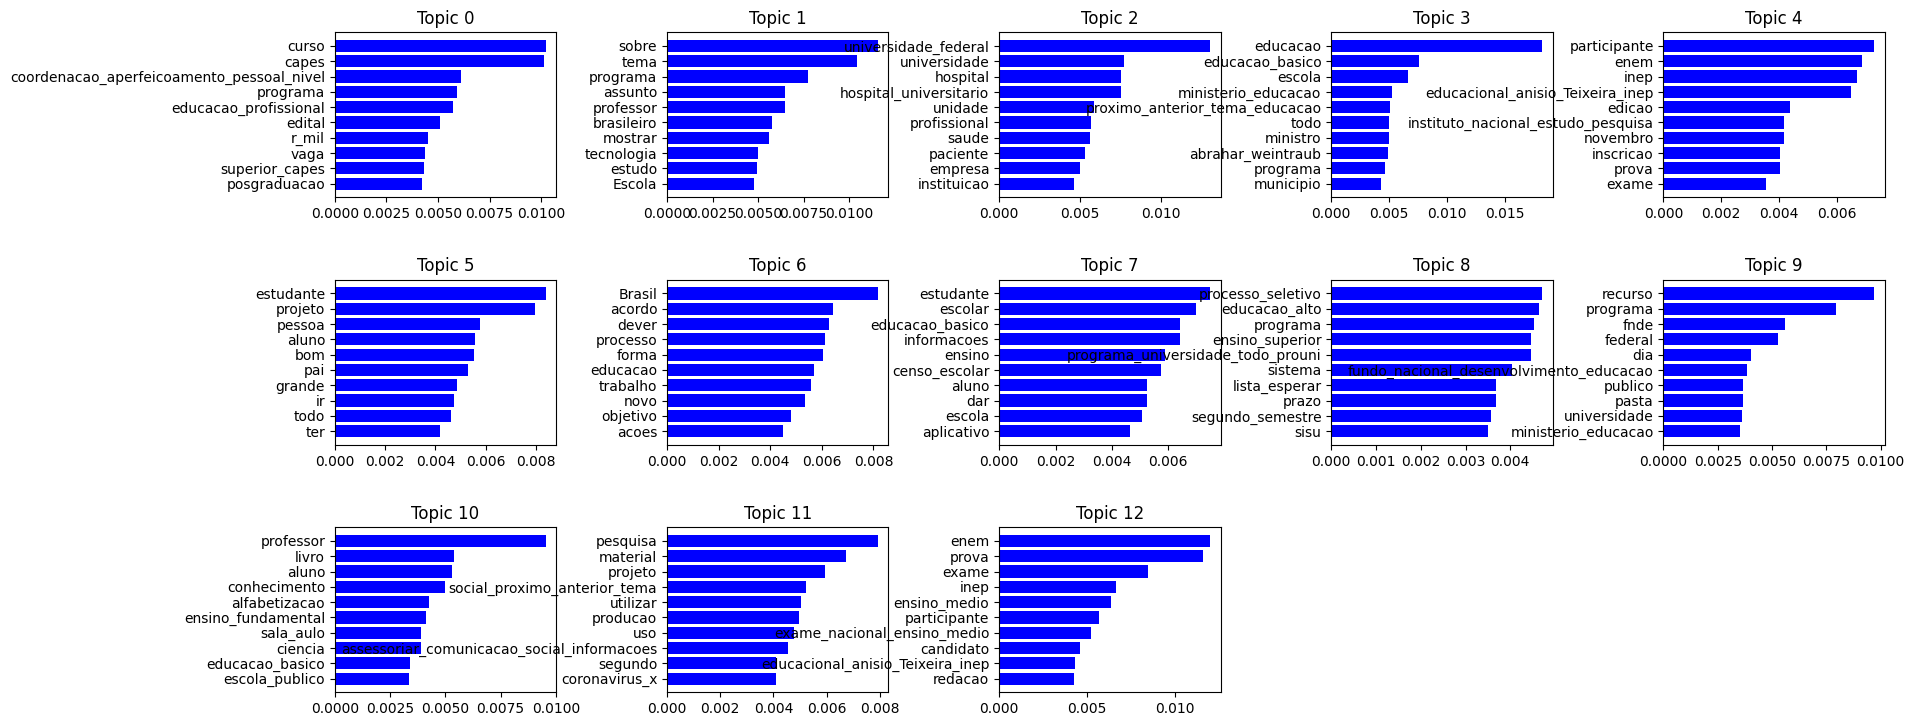

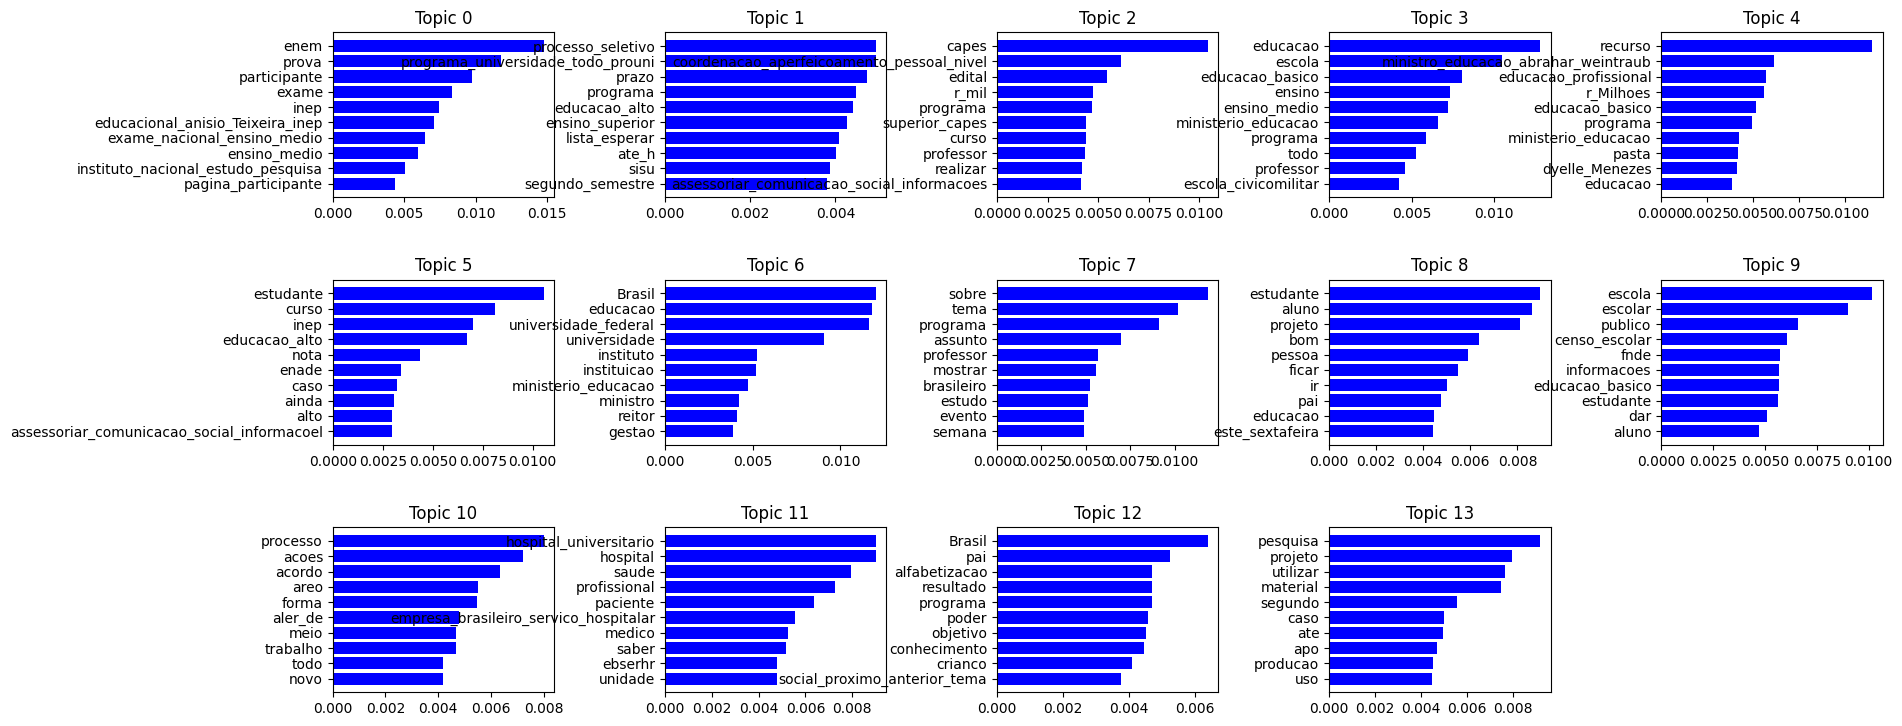

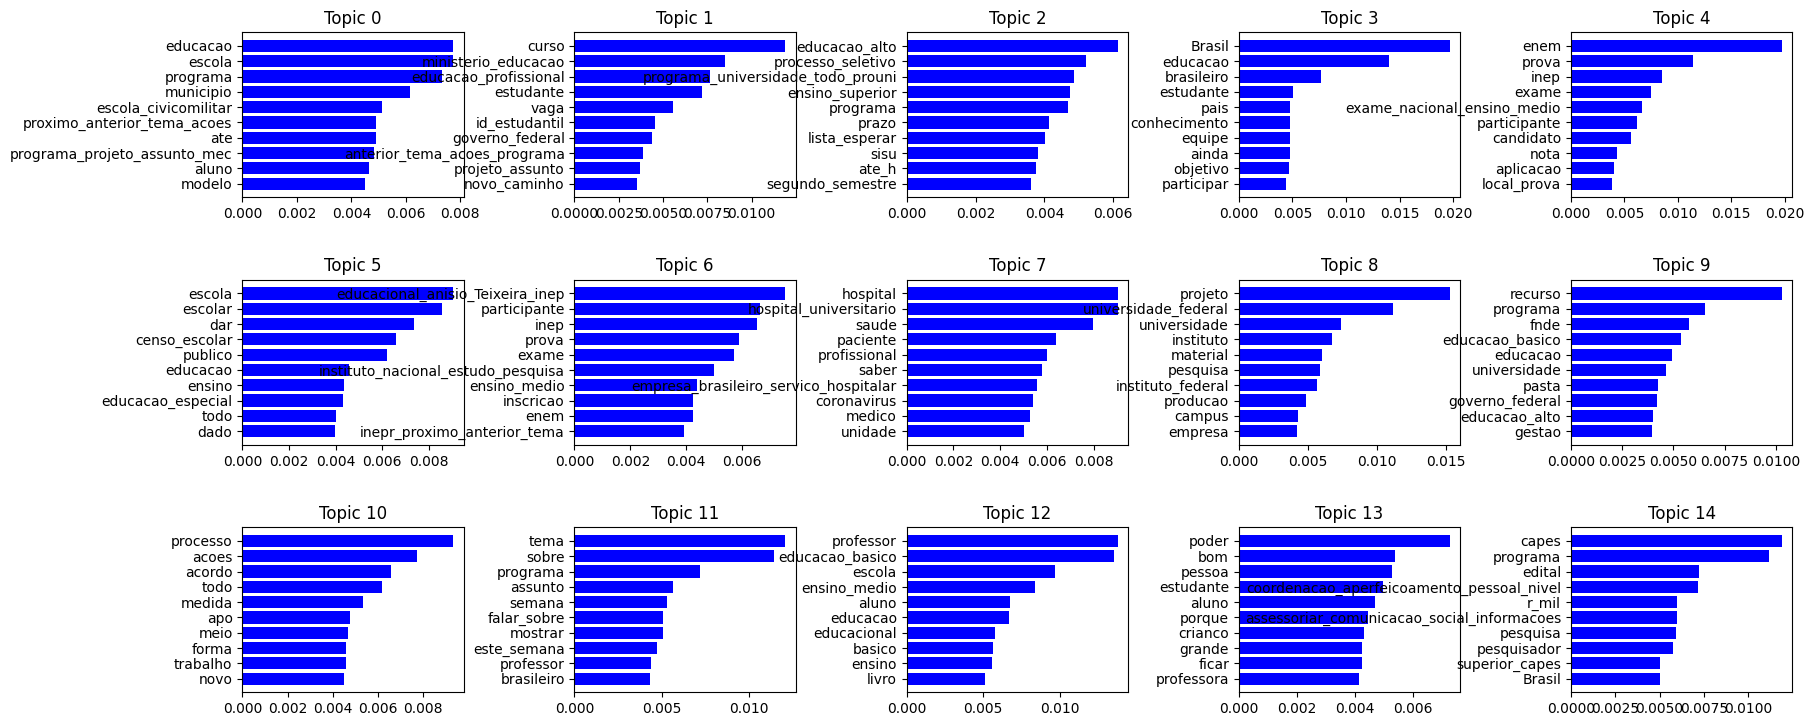

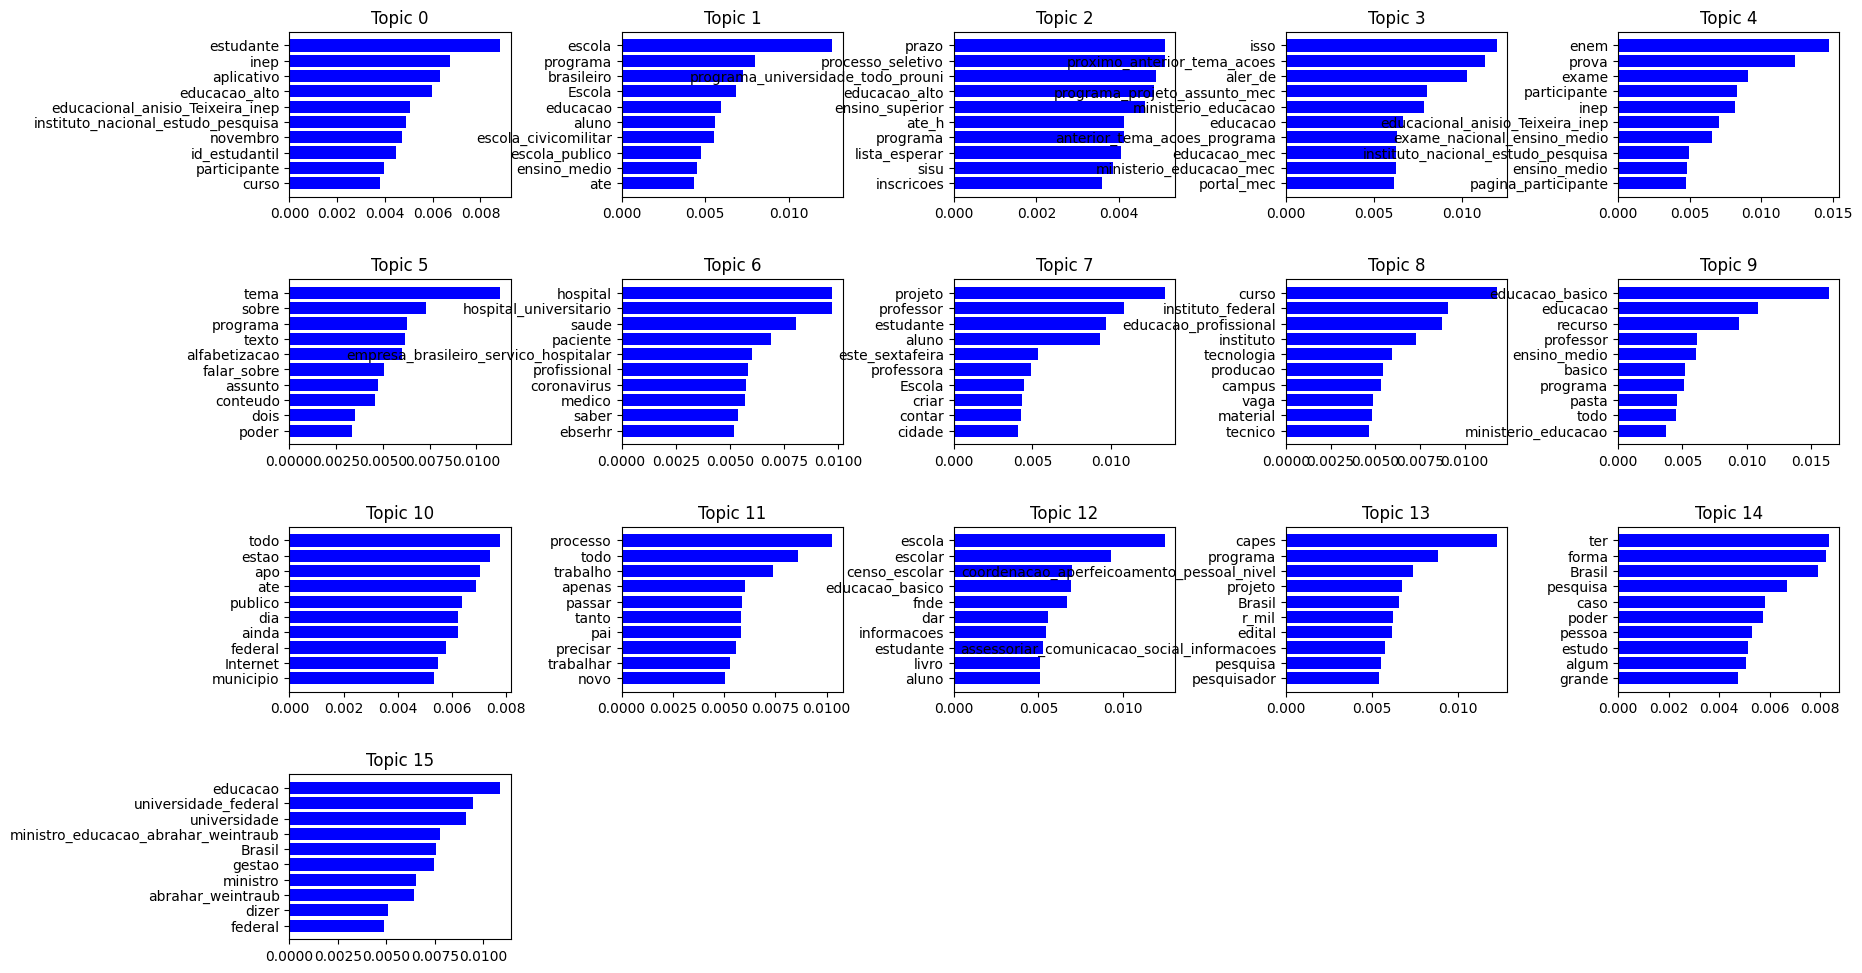

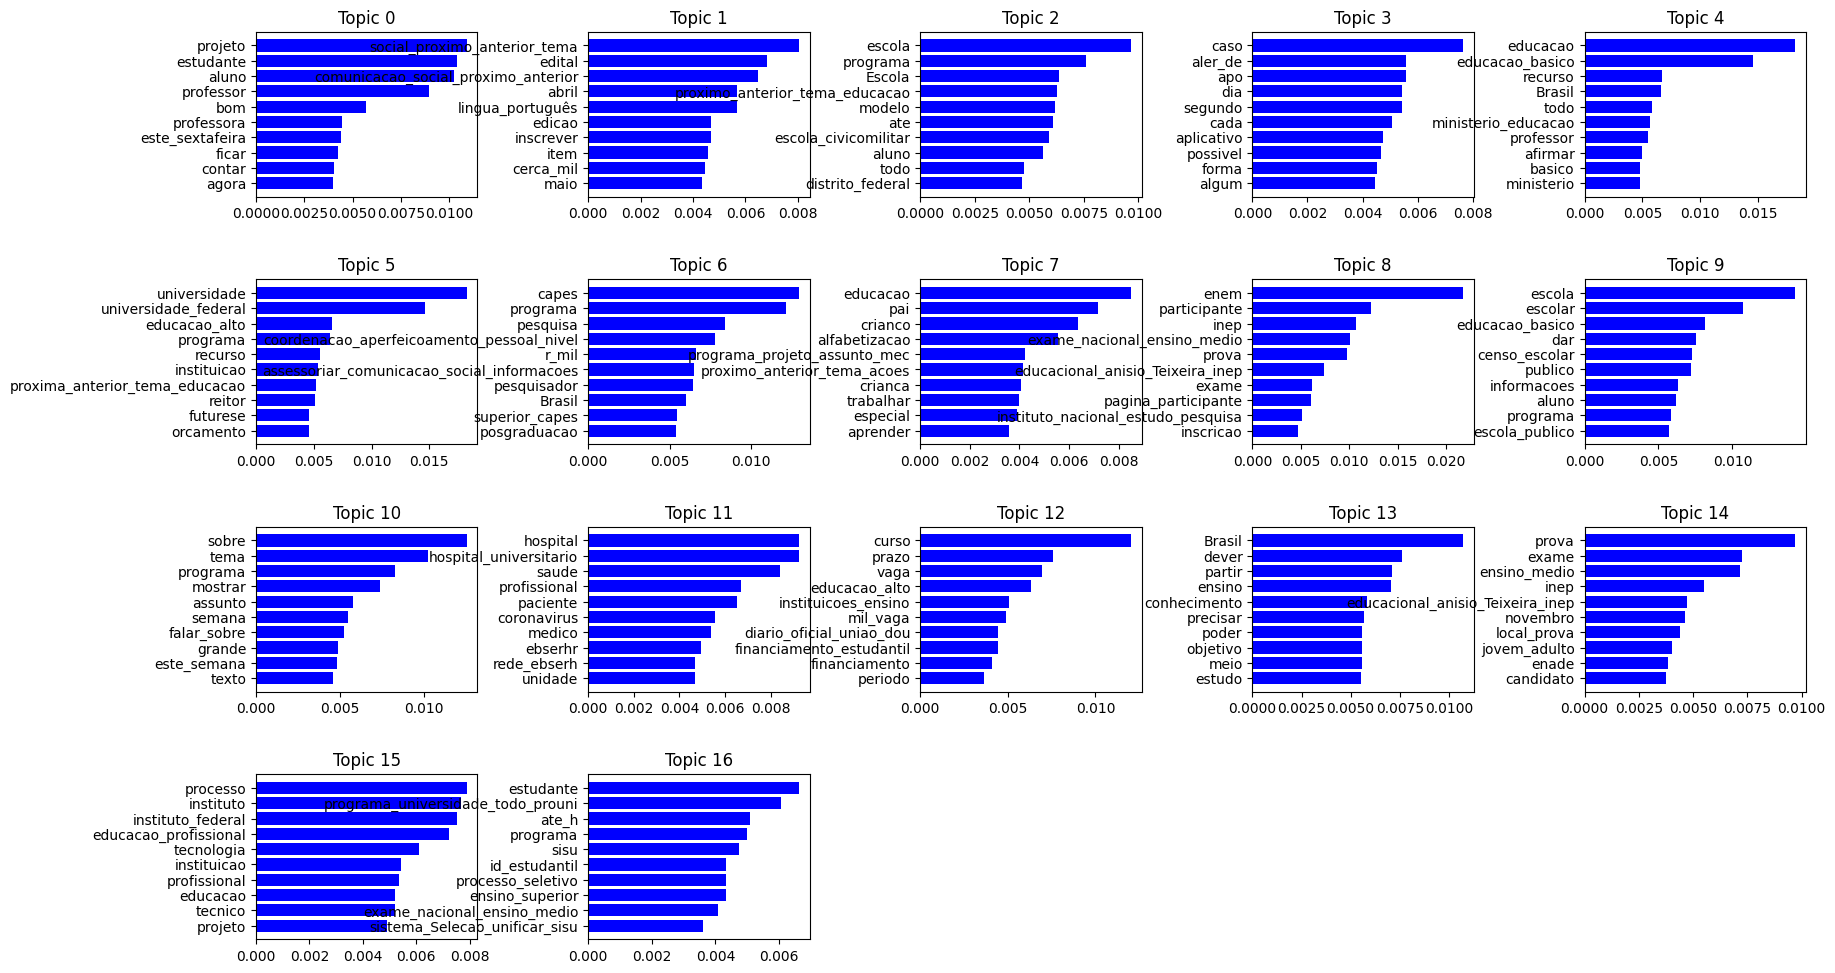

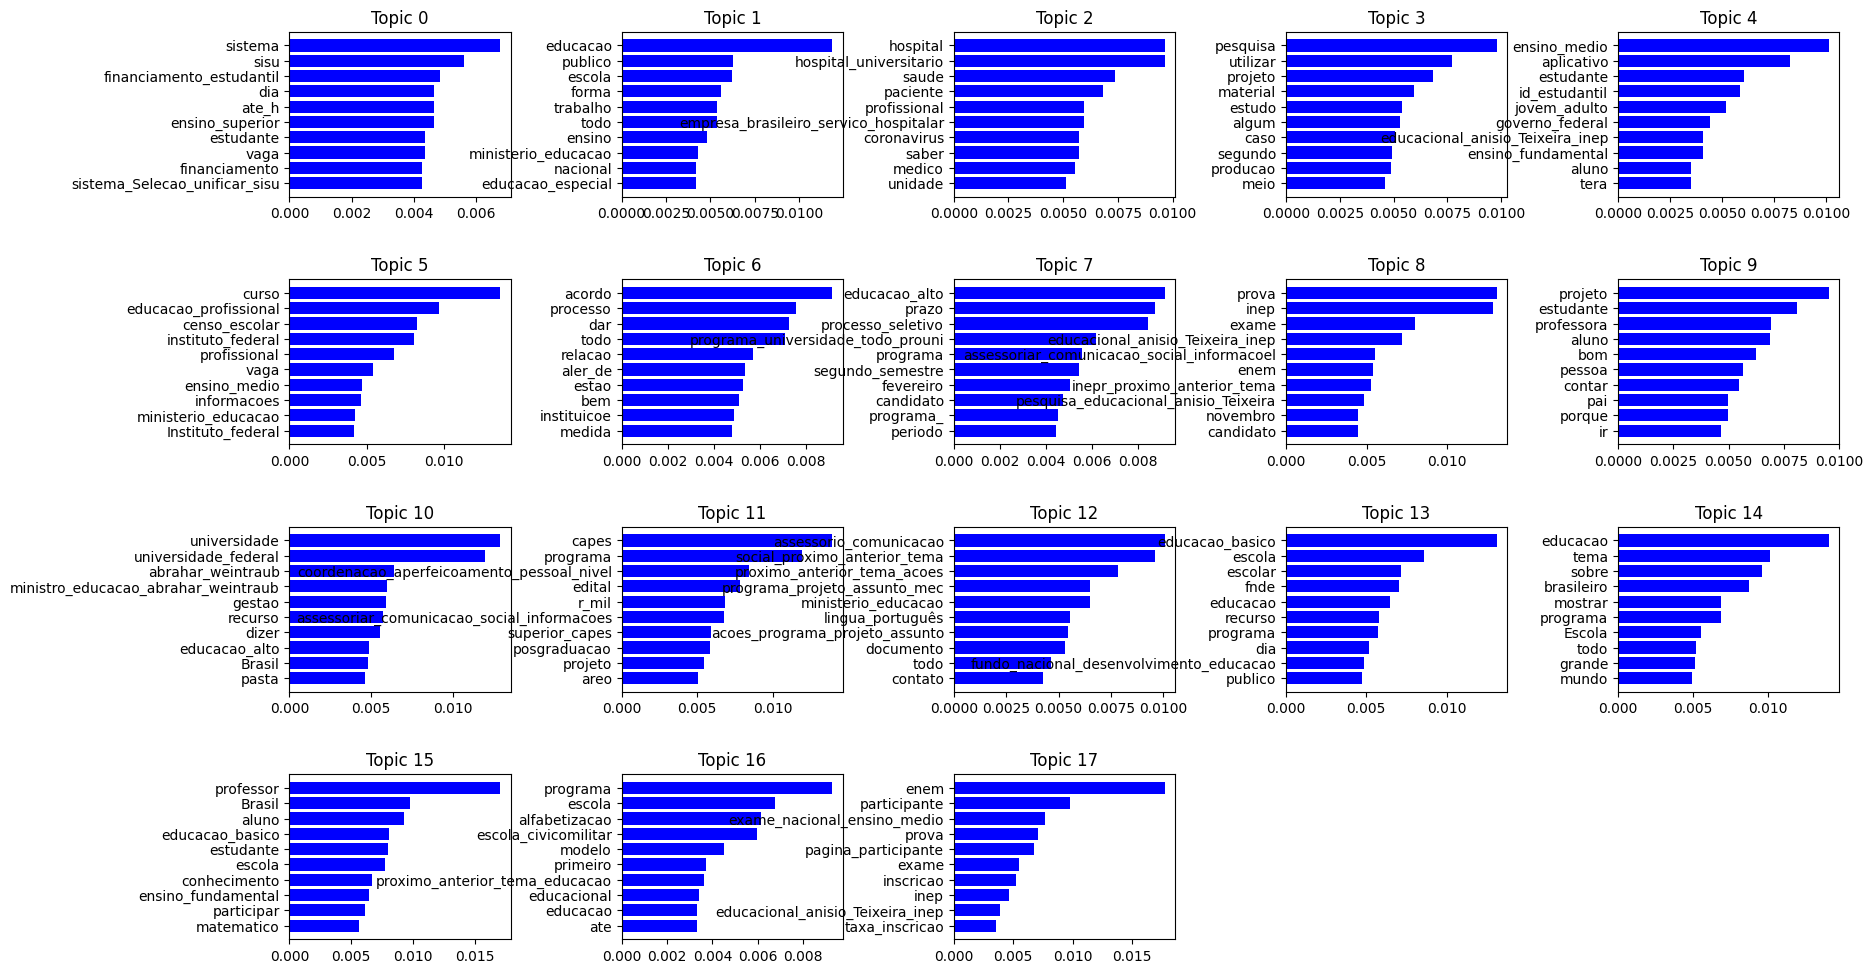

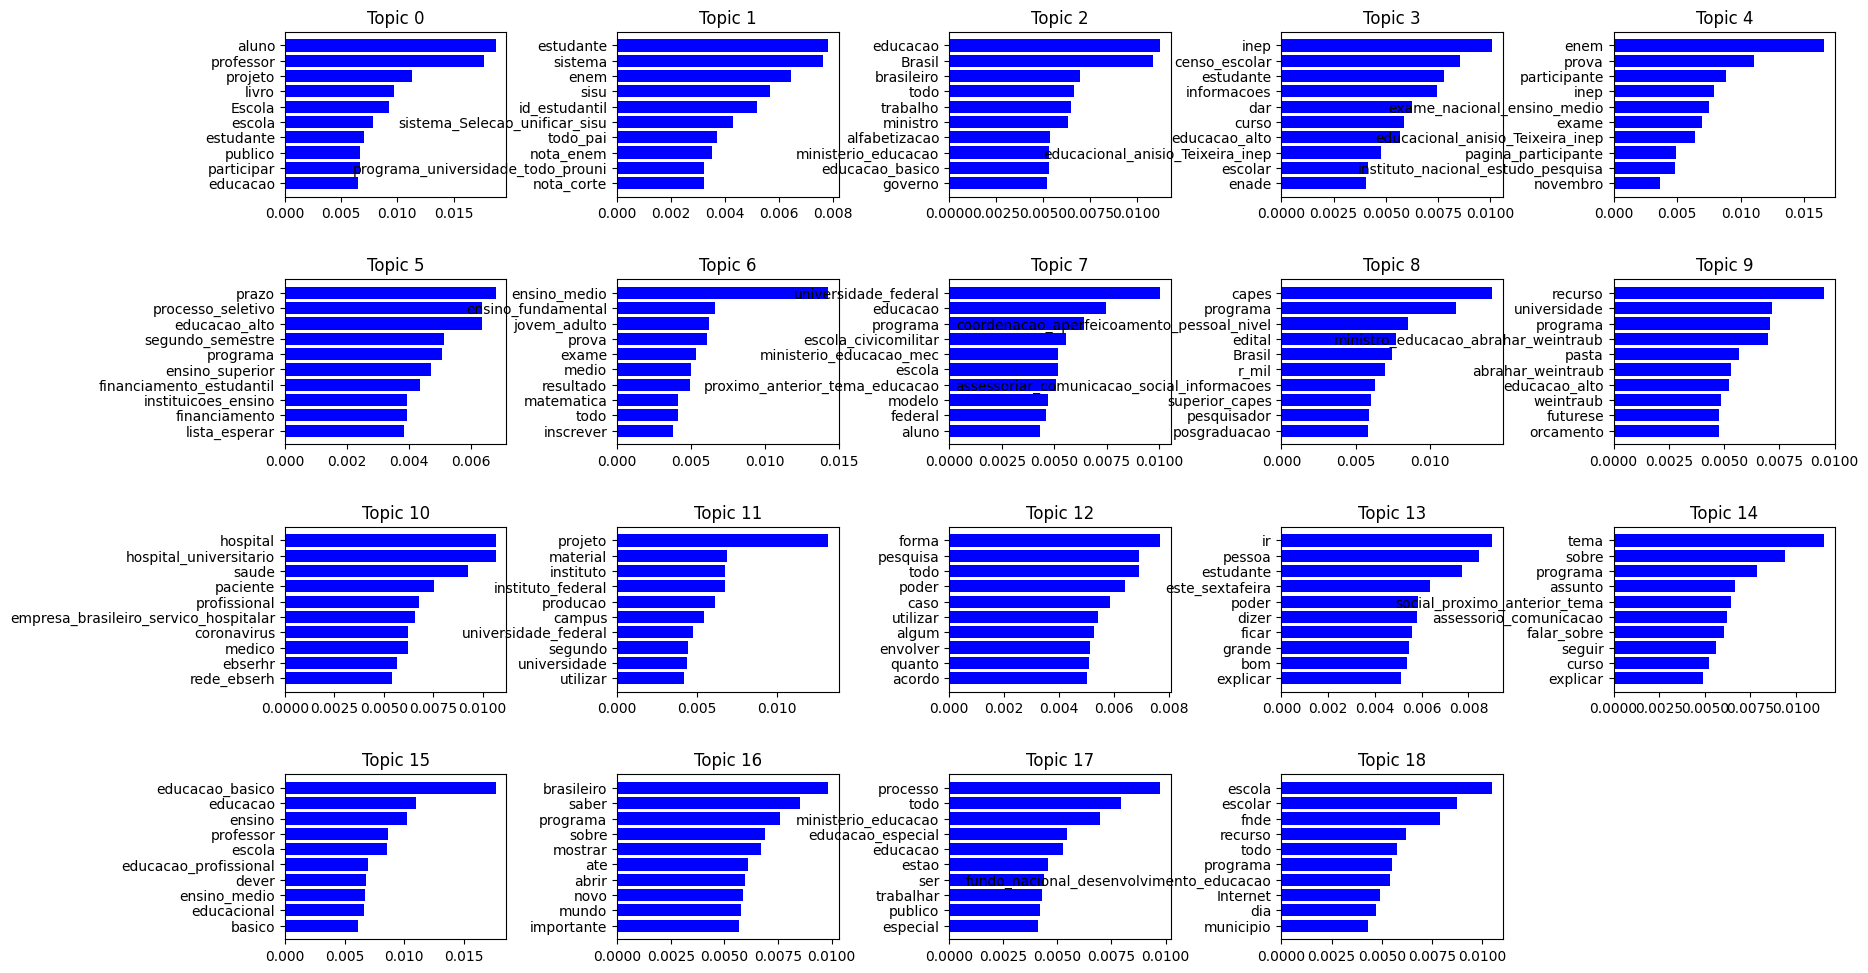

In [ ]:
for x in range(10,20): #construct the model for each k
  ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=x, id2word=dictionary, random_seed = 42)
  lda = malletmodel2ldamodel(ldamallet)

  # plot the model
  def plot_top_words(lda=lda,nb_topics=x,nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(sqrt(x))+1,round(sqrt(x))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

  plot_top_words()